In [2]:
import pandas as pd
import numpy as np

# Load data
customers = pd.read_csv('./data/Customers.csv')
transactions = pd.read_csv('./data/Transactions.csv')

# Inspect data
print(customers.head())
print(transactions.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


In [3]:
# Merge datasets
data = transactions.merge(customers, on='CustomerID')

# Aggregate transaction data for each customer
customer_features = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total transaction value
    'Quantity': 'sum',    # Total quantity purchased
    'TransactionID': 'count'  # Number of transactions
}).reset_index()

# Add customer profile information (Region)
customer_features = customer_features.merge(customers[['CustomerID', 'Region']], on='CustomerID')

print(customer_features.head())


  CustomerID  TotalValue  Quantity  TransactionID         Region
0      C0001     3354.52        12              5  South America
1      C0002     1862.74        10              4           Asia
2      C0003     2725.38        14              4  South America
3      C0004     5354.88        23              8  South America
4      C0005     2034.24         7              3           Asia


In [4]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'Region' column
encoder = LabelEncoder()
customer_features['Region'] = encoder.fit_transform(customer_features['Region'])

print(customer_features.head())


  CustomerID  TotalValue  Quantity  TransactionID  Region
0      C0001     3354.52        12              5       3
1      C0002     1862.74        10              4       0
2      C0003     2725.38        14              4       3
3      C0004     5354.88        23              8       3
4      C0005     2034.24         7              3       0


In [5]:
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = customer_features[['TotalValue', 'Quantity', 'TransactionID', 'Region']]

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

print(scaled_features[:5])  # Check the scaled data


[[-0.06170143 -0.12203296 -0.01145819  1.23740234]
 [-0.87774353 -0.44800021 -0.46749414 -1.41989693]
 [-0.40585722  0.20393428 -0.46749414  1.23740234]
 [ 1.03254704  1.67078689  1.35664965  1.23740234]
 [-0.78392861 -0.93695108 -0.92353008 -1.41989693]]


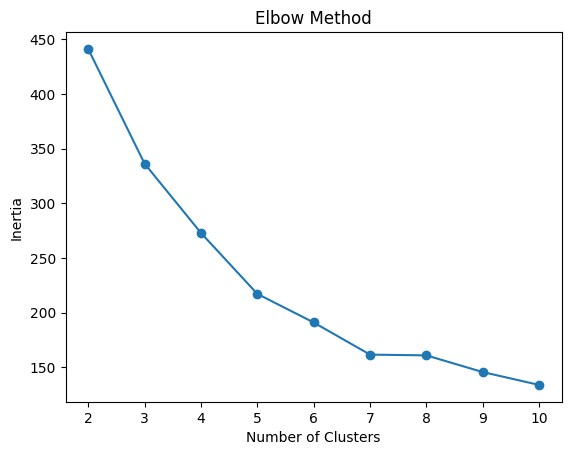

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Test different K values
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


In [7]:
# Fit K-Means with the chosen number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

print(customer_features.head())


  CustomerID  TotalValue  Quantity  TransactionID  Region  Cluster
0      C0001     3354.52        12              5       3        2
1      C0002     1862.74        10              4       0        1
2      C0003     2725.38        14              4       3        2
3      C0004     5354.88        23              8       3        0
4      C0005     2034.24         7              3       0        1


In [8]:
from sklearn.metrics import davies_bouldin_score

# Calculate DB Index
db_index = davies_bouldin_score(scaled_features, customer_features['Cluster'])
print(f"Davis-Bouldin Index: {db_index}")


Davis-Bouldin Index: 1.0259136043470107


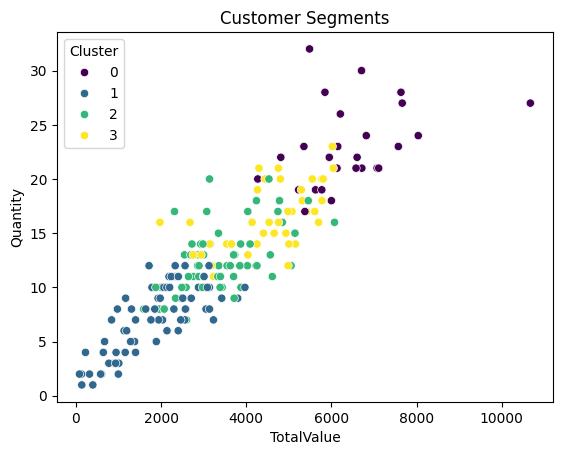

In [9]:
import seaborn as sns

# Scatter plot of clusters (e.g., based on TotalValue and Quantity)
sns.scatterplot(
    x=customer_features['TotalValue'],
    y=customer_features['Quantity'],
    hue=customer_features['Cluster'],
    palette='viridis'
)
plt.title('Customer Segments')
plt.show()
